In [1]:
import re
import pandas as pd
import collections
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm
import os
import datetime
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from collections import Counter
from copy import deepcopy

In [60]:
class Sentimentor:
    def __init__(self, twitter_data_path, sentiment_path, output_path, k=None):
        self.tweet_df = pd.read_csv(twitter_data_path).dropna()
        self.output_path = output_path

        if k != None:
            idxs = random.sample(list(np.arange(len(self.tweet_df))), min(k, len(self.tweet_df)))
            self.tweet_df = self.tweet_df.iloc[idxs]

        self.sentiment_df = pd.read_csv(sentiment_path, sep="\t")

        self.__run()
        self.__save()

    def __get_sentiment(self, tweet):
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(tweet)

        freqs = collections.Counter(tokens)
        score = 0
        n = 0
        df1 = self.sentiment_df[self.sentiment_df["word"].isin(tokens)]
        for _, row in df1.iterrows():
            word = row['word']
            happiness_average = row['happiness_average']
            freq = freqs[word]
            score += freq * happiness_average
            n += freq

        if n != 0:
            score = score / n
        else:
            score = 0.0
        return score

    def __get_week_number(self, tweet_timestamp):
        day = tweet_timestamp.split(" ")[0].split("-")
        date_obj = datetime.date(int(day[0]), int(day[1]), int(day[2]))
        week_number = date_obj.isocalendar()[1]
        return week_number

    def __get_hashtags(self, tweet):
        try:
            regex_code = "(?<=^|(?<=[^a-zA-Z0-9-_\.]))#([A-Za-z]+[A-Za-z0-9-_]+)"
            hashtags = re.findall(regex_code, tweet)
            return hashtags
        except TypeError:
            return []

    def __run(self):
        tqdm.pandas()
        sentiments = self.tweet_df['tweet'].progress_apply(self.__get_sentiment)

        tqdm.pandas()
        week_numbers = self.tweet_df['tweet_timestamp'].progress_apply(self.__get_week_number)

        self.tweet_df['sentiment_score'] = sentiments
        self.tweet_df['week_number'] = week_numbers
        return self.tweet_df

    def __group(self, df, column):
        grouped_by = {"mean": df.groupby("week_number")[column].mean(),
                      'std': df.groupby("week_number")[column].std(),
                      'N': df.groupby("week_number")[column].count()}
        return grouped_by

    def __save(self):
        self.tweet_df.to_csv(self.output_path, index=False)

    def plot_sentiment(self, title):
        grouped_by = self.__group(self.tweet_df, 'sentiment_score')
        week_numbers = grouped_by['mean'].keys()._data
        means = grouped_by['mean'].values
        stds = grouped_by['std'].values
        Ns = grouped_by['N'].values
        
        fig = plt.figure(figsize=(20,12))

        plt.plot(week_numbers, means, linewidth=9)

        # lower confidence
        lower = [stats.norm.interval(0.95, loc=means[i], scale=stds[i] / np.sqrt(Ns[i]))[0] for i in range(len(Ns))]
        plt.plot(week_numbers, lower, color='black')

        # upper confidence
        higher = [stats.norm.interval(0.95, loc=means[i], scale=stds[i] / np.sqrt(Ns[i]))[1] for i in range(len(Ns))]
        plt.plot(week_numbers, higher, color='black')

        for month_label, month_number in [('April', 4), ('May', 5), ('June', 6), ('July', 7)]:
            vline = datetime.date(2020, month_number, 1).isocalendar()[1]
            plt.vlines(vline, min(lower), max(higher), colors='black', label=month_label, linewidth=4,
                       linestyles='dashed')
            plt.text(vline + 0.1, min(lower), month_label, fontsize=20)

        plt.fill_between(week_numbers, lower, higher, alpha=0.2)

        plt.xticks(week_numbers)
        plt.title(title, fontsize=20)
        plt.xlabel("Week number", fontsize=20)
        plt.ylabel("Sentiment score", fontsize=20)
        # plt.grid()
        plt.show()

    def analyse_hashtags(self, n):
        hashtags = self.tweet_df['tweet'].apply(self.__get_hashtags)
        hashtags = [item for sublist in hashtags for item in sublist]
        values, counts = np.unique(hashtags, return_counts=True)
        sort_idx = np.argsort(-counts)
        
        values = values[sort_idx][0:n]
        counts = counts[sort_idx][0:n]
#         for i in range(n):
#             print(values[i], counts[i])
        print(list(zip(values,counts)))


    def plot_hashtags(self, hashtags, title):
        hashtags_column = self.tweet_df['tweet'].apply(self.__get_hashtags)
        df_temp = deepcopy(self.tweet_df)
        df_temp['hashtags'] = hashtags_column

        f = lambda row_hashtags: [hashtag in row_hashtags for hashtag in hashtags]
        idxs = np.array(list(df_temp['hashtags'].apply(f)))

        minn = 10 * 10 ** 6
        maxx = -10 * 10 ** 6
        
        fig = plt.figure(figsize=(20,12))

        for i, hashtag in enumerate(hashtags):
            df_temp_hashtag = df_temp.loc[idxs[:, i]]

            grouped_by = self.__group(df_temp_hashtag, 'sentiment')
            week_numbers = grouped_by['mean'].keys()._data
            means = grouped_by['mean'].values
            stds = grouped_by['std'].values
            Ns = grouped_by['N'].values

            plt.plot(week_numbers, means, linewidth=9, label=hashtag)


            minn = min(minn, min(means))
            maxx = max(maxx, max(means))

        for month_label, month_number in [('April', 4), ('May', 5), ('June', 6), ('July', 7)]:
            vline = datetime.date(2020, month_number, 1).isocalendar()[1]
            plt.vlines(vline, minn, maxx, colors='black', linewidth=4,
                       linestyles='dashed')
            plt.text(vline + 0.1, minn, month_label, fontsize=20)

        plt.xticks(week_numbers)
        plt.title(title, fontsize=20)
        plt.xlabel("Week number", fontsize=20)
        plt.ylabel("Sentiment score", fontsize=20)
        plt.legend()
        # plt.grid()
        plt.show()

    def plot_emotions(self, title):
        emotions = ['fear', 'anger', 'happiness', 'sadness']
        minn = 10 * 10 ** 6
        maxx = -10 * 10 ** 6
        
        fig = plt.figure(figsize=(20,12))
        
        for emotion in emotions:
            grouped_by = self.__group(self.tweet_df, '{}_intensity'.format(emotion))

            week_numbers = grouped_by['mean'].keys()._data
            means = grouped_by['mean'].values
            stds = grouped_by['std'].values
            Ns = grouped_by['N'].values

            plt.plot(week_numbers, means, linewidth=9, label=emotion)

            # lower confidence
            lower = [stats.norm.interval(0.95, loc=means[i], scale=stds[i] / np.sqrt(Ns[i]))[0] for i in range(len(Ns))]

            # upper confidence
            higher = [stats.norm.interval(0.95, loc=means[i], scale=stds[i] / np.sqrt(Ns[i]))[1] for i in
                      range(len(Ns))]

            minn = min(minn, min(lower))
            maxx = max(maxx, max(higher))

        for month_label, month_number in [('April', 4), ('May', 5), ('June', 6), ('July', 7)]:
            vline = datetime.date(2020, month_number, 1).isocalendar()[1]
            plt.vlines(vline, minn, maxx, colors='black', linewidth=4,
                       linestyles='dashed')
            plt.text(vline + 0.1, minn, month_label, fontsize=20)

        plt.xticks(week_numbers)
        plt.title(title, fontsize=20)
        plt.xlabel("Week number", fontsize=20)
        plt.ylabel("Sentiment score", fontsize=20)
        plt.legend(fontsize=20)
        plt.show()
        
class Sentimentor_load(Sentimentor):

    def __init__(self, twitter_sentiment_path, sentiment_path):
        self.tweet_df = pd.read_csv(twitter_sentiment_path).dropna()
        self.tweet_df = self.tweet_df[self.tweet_df['tweet_timestamp'] > '2020-03-1 1:30:00']


        self.sentiment_df = pd.read_csv(sentiment_path, sep="\t")


In [61]:

sentimentor_can = Sentimentor_load("../CAN_sentiment.csv", "../Data_Set_S1.txt")
sentimentor_uk = Sentimentor_load("../UK_sentiment.csv", "../Data_Set_S1.txt")

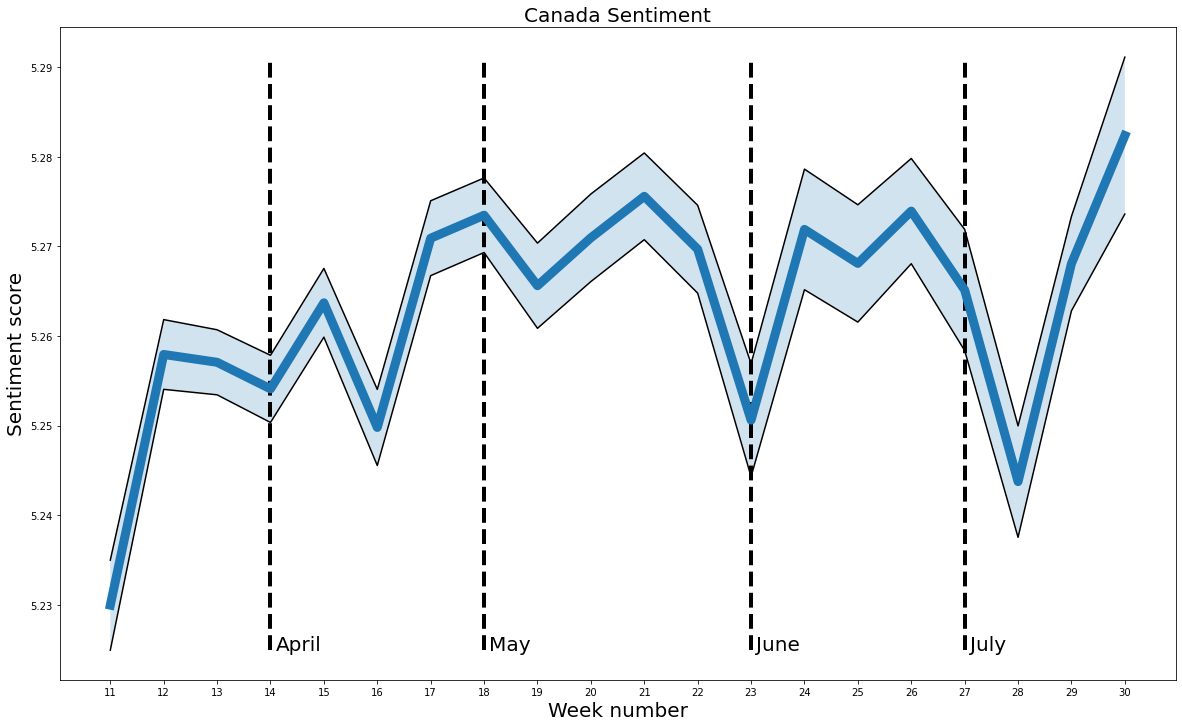

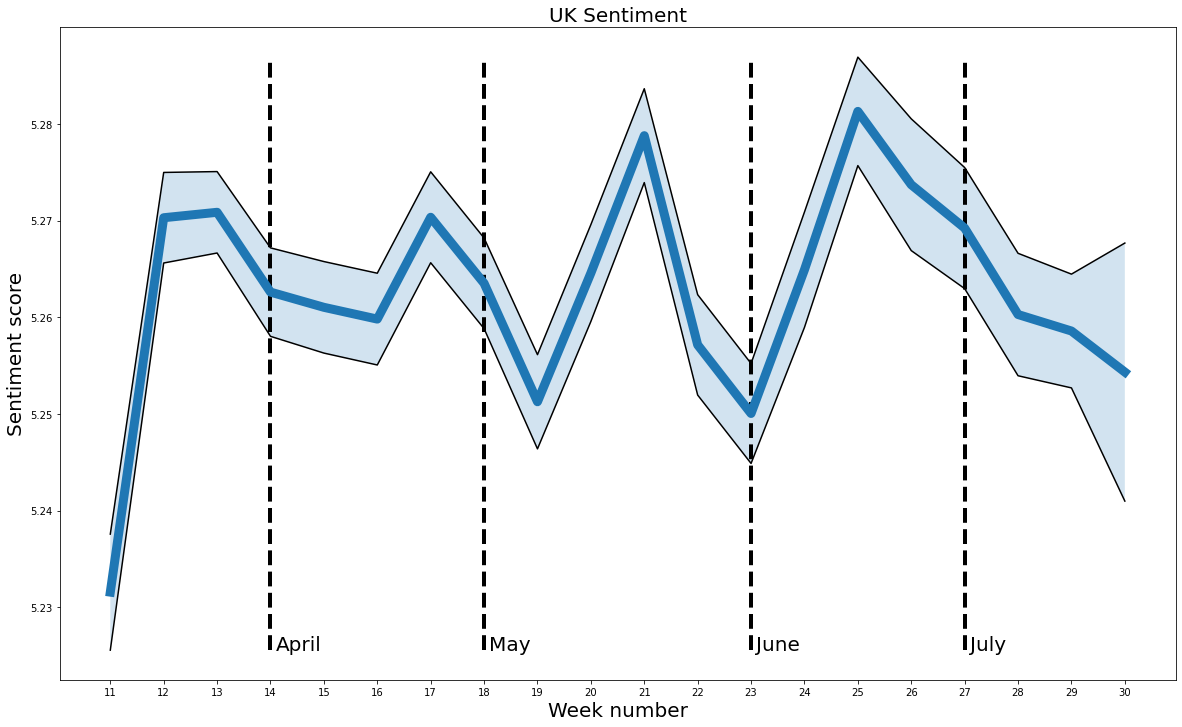

In [38]:
sentimentor_can.plot_sentiment("Canada Sentiment")
sentimentor_uk.plot_sentiment("UK Sentiment")

Above are plots showing how the sentiment scores evolve over time for the two countries. The plots include the 95% confindence intervals. 

Overall, the sentiment score are oscillating a fair amount. In other words, there does seem to be a time-dependency on the sentiment scores. The question is if the oscillations are due to real-life events or something else

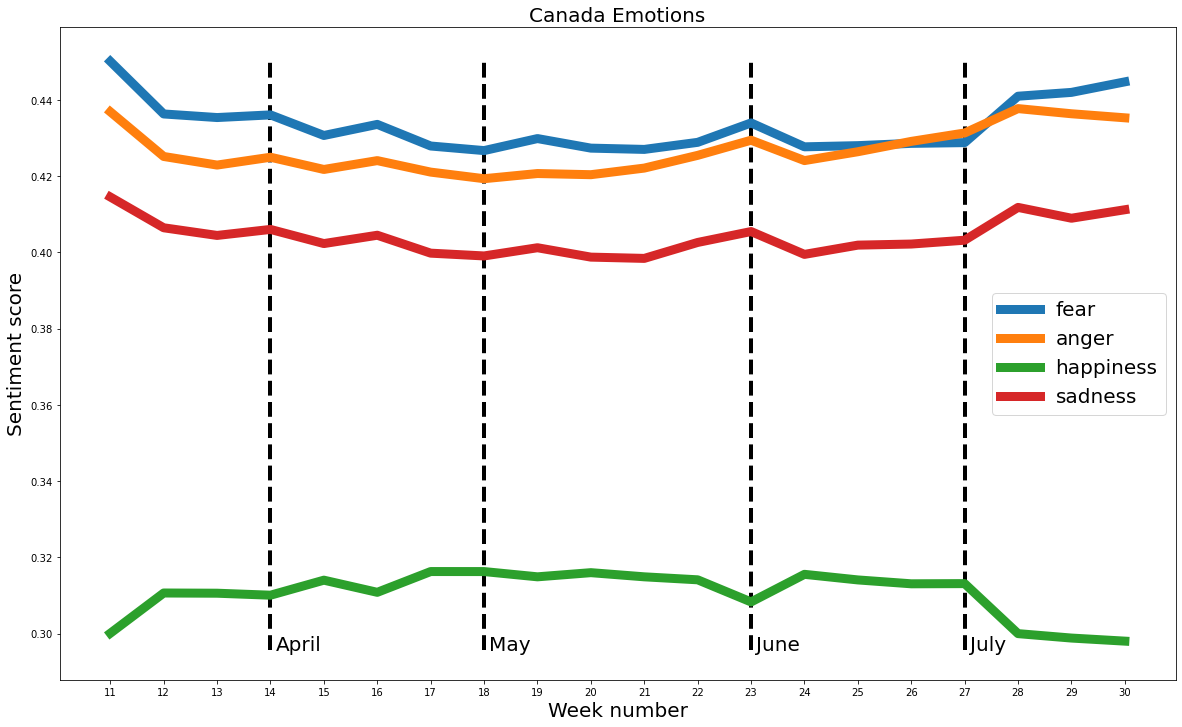

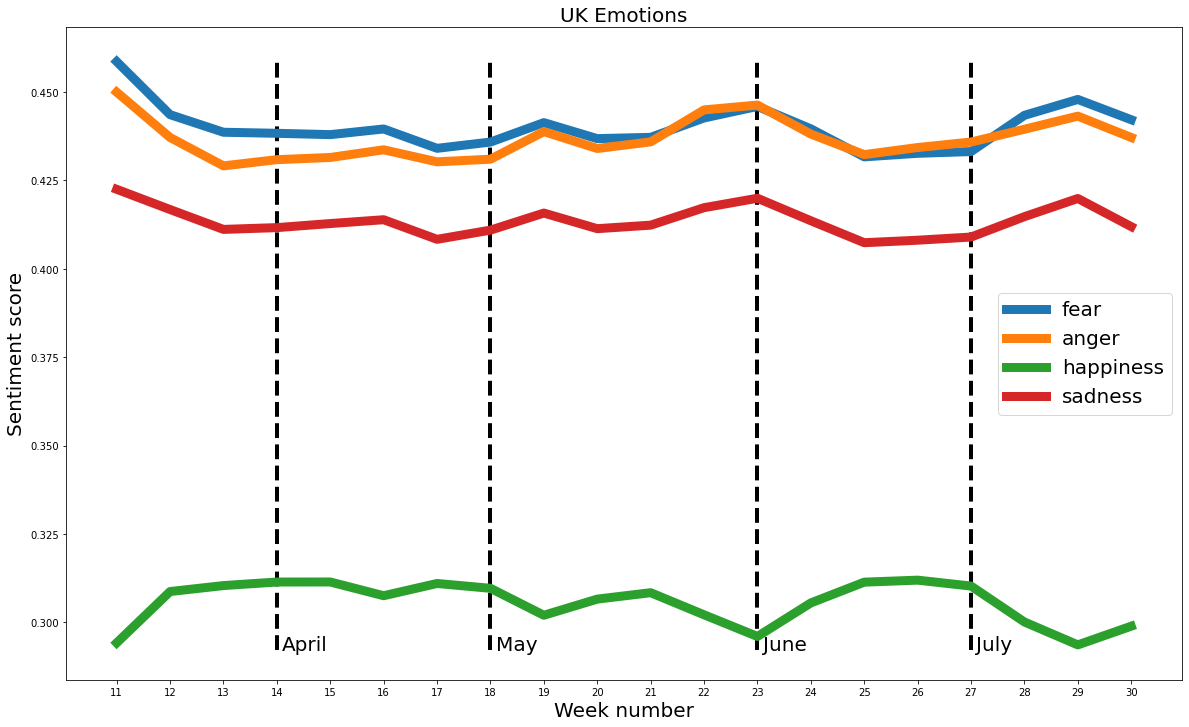

In [39]:
sentimentor_can.plot_emotions("Canada Emotions")
sentimentor_uk.plot_emotions("UK Emotions")

Above, you can see the emotions plotted over time for the two countries. This is NOT the sentiment score. The values are created by the authors of the dataset and they are based on some machine learning NLTK method. 

Unlike the sentiment scores, the emotions don't really seem to be time-dependant. Happiness seems by far the less dominating emotion, which makes sense in a global pandemic, but beware: We don't know how emotion values would be OUTSIDE the pandemic. Maybe people were not more or less happy during the pandemic compared to other time periods. Maybe people just prefer tweeting angry tweets than happy tweets. 

In [62]:
print("Top 50 used hashtags")
print("\nCANADA:\n")
sentimentor_can.analyse_hashtags(50)
print("\nUK:\n")
sentimentor_uk.analyse_hashtags(50)

Top 50 used hashtags

CANADA:

[('COVID19', 28687), ('Covid_19', 12700), ('coronavirus', 8254), ('COVID', 7059), ('cdnpoli', 5833), ('COVID-19', 5210), ('covid19', 4964), ('covid', 3497), ('covid_19', 2270), ('onpoli', 2108), ('Canada', 2073), ('COVID__19', 1905), ('bcpoli', 1770), ('Coronavirus', 1764), ('pandemic', 1684), ('yeg', 1638), ('Covid19', 1638), ('ottnews', 1585), ('yyc', 1537), ('COVID_19', 1430), ('covid19Canada', 1378), ('ableg', 1293), ('COVID19AB', 1242), ('Ontario', 1187), ('Toronto', 1116), ('COVIDCanada', 1032), ('Covid', 1026), ('corona', 1008), ('canada', 998), ('StayHome', 989), ('HamOnt', 907), ('SocialDistancing', 849), ('COVID19Ontario', 849), ('India', 822), ('COVID19Canada', 816), ('news', 801), ('Covid-19', 795), ('CoronavirusPandemic', 789), ('Corona', 788), ('mentalhealth', 786), ('stayhome', 772), ('covid-19', 771), ('FlattenTheCurve', 731), ('socialdistancing', 721), ('CoronaVirus', 701), ('COVID19BC', 700), ('Vancouver', 661), ('abpoli', 661), ('health

The above shows the top 50 hashtags used for both countries. The number written next to the hashtag is the number of times it was used.  A lot of the hashtags are just different ways of writing covid, but there are also a few interesting ones. 

For Canada, the hashtags 'SocialDistancing', 'StayHome' and 'mentalhealth' are quite popular. They are very much related to the pandemic. People we were worried about losing their sanity when being locked up in their small flats. 

For UK, some important ones are 'lockdown', 'NHS' and 'menthalhealth'. Especially 'NHS' is interesting because it shows something about the culture in the UK where they are very proud of their public health system. 


Below, we are going to examine the sentiments scores of the tweets containing the above-mentioned hashtags. We will plot those sentiment scores against the week number. Maybe the hashtags' sentiment scores evolve in an interesting way over time?

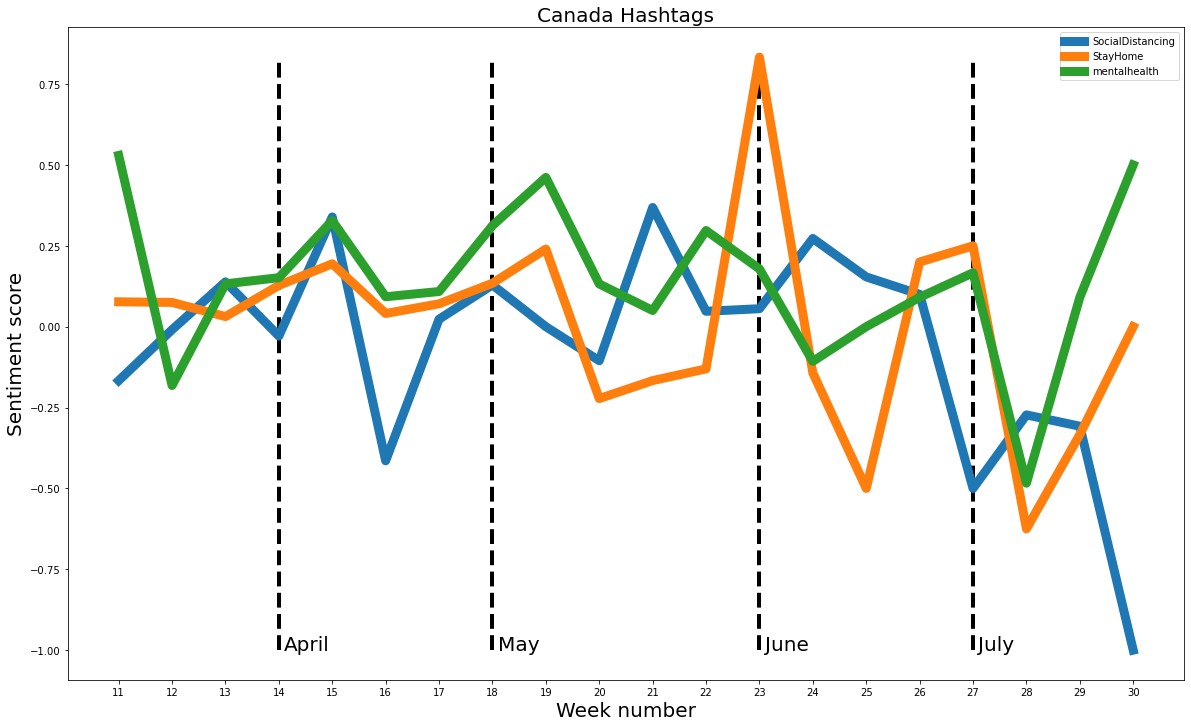

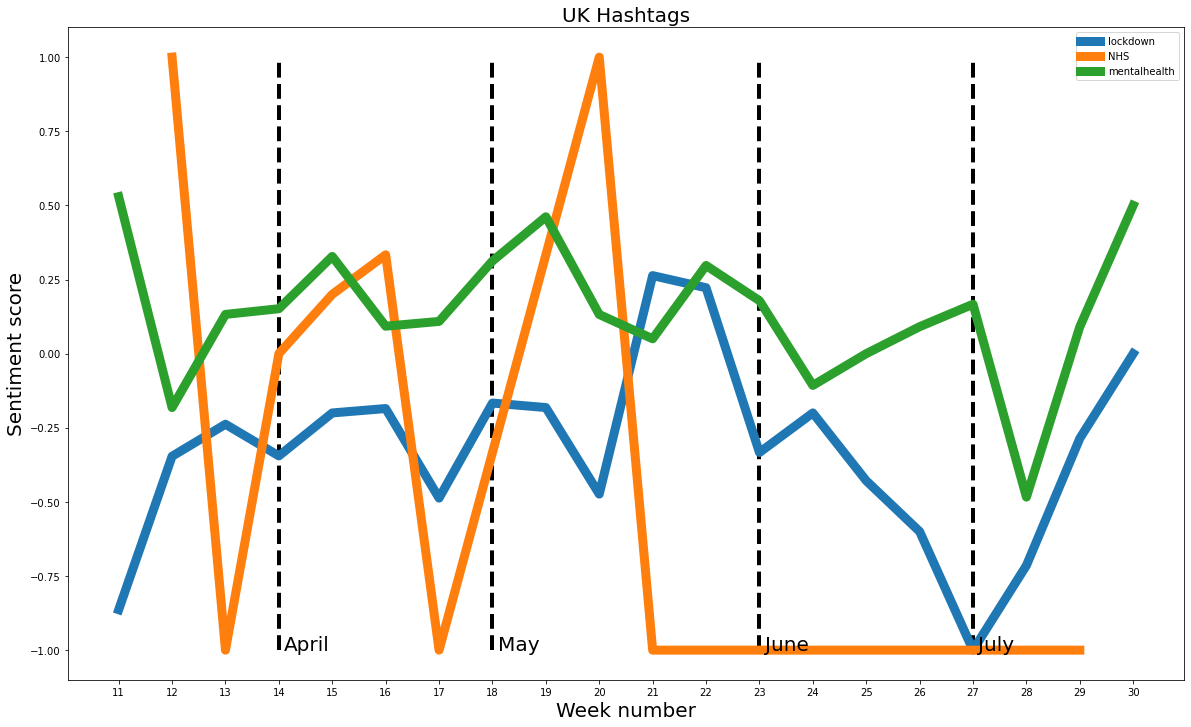

In [48]:
sentimentor_can.plot_hashtags(['SocialDistancing', 'StayHome', 'mentalhealth'], "Canada Hashtags")
sentimentor_can.plot_hashtags(['lockdown', 'NHS', 'mentalhealth'], "UK Hashtags")

Judging by the plots above, it seems there is NOT any time-dependancy for hashtags' sentiment scores. Furthermore, we can't really tell sentiment scores for the different hashtags apart. 